In [1]:
import pandas as pd
from pvlib import pvsystem
import pvlib
from cpvlib import cpvsystem
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def generacionVidrio(params, system, data):
    dii = pvlib.irradiance.beam_component(system['surface_tilt'],
                                          system['surface_azimuth'],
                                          solar_zenith=data['solar_zenith'],
                                          solar_azimuth=data['solar_azimuth'],
                                          dni=data['dni'])

    aoi = pvlib.irradiance.aoi(system['surface_tilt'], 
                               system['surface_azimuth'],
                               solar_zenith=data['solar_zenith'],
                               solar_azimuth=data['solar_azimuth'])

    poa_sky=pvlib.irradiance.get_sky_diffuse(system['surface_tilt'],
                                             system['surface_azimuth'],
                                             solar_zenith=data['solar_zenith'],
                                             solar_azimuth=data['solar_azimuth'],
                                             ghi=data['ghi'],
                                             dhi=data['dhi'],
                                             dni=data['dni'],
                                             dni_extra=None, 
                                             airmass=None, 
                                             model='isotropic', 
                                             model_perez='allsitescomposite1990')

    poa_ground=pvlib.irradiance.get_ground_diffuse(system['surface_tilt'], 
                                                   ghi=data['ghi'], 
                                                   albedo=0.25, 
                                                   surface_type=None)

    poa_irrad=pvlib.irradiance.poa_components(aoi=aoi, 
                                              dni=data['dni'], 
                                              poa_sky_diffuse=poa_sky, 
                                              poa_ground_diffuse=poa_ground)

    effectiveIrradiance = poa_irrad.poa_direct * np.absolute(np.cos(aoi)) * pvlib.iam.ashrae(aoi) + poa_irrad.poa_diffuse

    tempcell=pvlib.temperature.pvsyst_cell(poa_irrad.poa_global, 
                                       data['temp_air'], 
                                       data['wind_speed'])

    IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
        effective_irradiance=effectiveIrradiance,
        temp_cell=tempcell,
        alpha_sc=mod_params_vidrio['alpha_sc'],
        a_ref=mod_params_vidrio['a_ref'],
        I_L_ref=mod_params_vidrio['I_L_ref'],
        I_o_ref=mod_params_vidrio['I_o_ref'],
        R_sh_ref=mod_params_vidrio['R_sh_ref'],
        R_s=mod_params_vidrio['R_s'],
        EgRef=mod_params_vidrio['EgRef'],
    )

    dc_pv = pvlib.pvsystem.singlediode(
        photocurrent=IL,
        saturation_current=I0,
        resistance_series=Rs,
        resistance_shunt=Rsh,
        nNsVth=nNsVth,
        ivcurve_pnts=100,
        method='lambertw'
    )
    
    dc = pd.DataFrame(dc_pv['p_mp'], index = data.index)
    
    return dc

def generacionCPV(paramsCPV, paramsFlatPlate, system, data):
    static_hybrid_sys = cpvsystem.StaticHybridSystem(
        surface_tilt=system['surface_tilt'],
        surface_azimuth=system['surface_azimuth'],
        module_cpv=None,
        module_flatplate=None,
        module_parameters_cpv=paramsCPV,
        module_parameters_flatplate=paramsFlatPlate,
        modules_per_string=1,
        strings_per_inverter=1,
        inverter=None,
        inverter_parameters=None,
        racking_model="insulated",
        losses_parameters=None,
        name=None,
    )

    dii_effective, poa_flatplate_static_effective = static_hybrid_sys.get_effective_irradiance(
        data['solar_zenith'],
        data['solar_azimuth'],
        #iam_param=0.7,
        #aoi_limit=55,
        dii=None,
        ghi=data['ghi'],
        dhi=data['dhi'],
        dni=data['dni']
    )


    temp_cell_35, temp_cell_flatplate = static_hybrid_sys.pvsyst_celltemp(
        dii=dii_effective,
        poa_flatplate_static=poa_flatplate_static_effective,
        temp_air=data['temp_air'],
        wind_speed=data['wind_speed']
    )

    diode_parameters_cpv, diode_parameters_flatplate = static_hybrid_sys.calcparams_pvsyst(
        dii=dii_effective,
        poa_flatplate_static=poa_flatplate_static_effective,
        temp_cell_cpv=temp_cell_35,
        temp_cell_flatplate=temp_cell_flatplate,
    )

    dc_cpv, dc_flatplate = static_hybrid_sys.singlediode(
        diode_parameters_cpv, diode_parameters_flatplate)

    uf_cpv = static_hybrid_sys.get_global_utilization_factor_cpv(data['airmass_absolute'],
                                                                 data['temp_air'])

    return dc_cpv['p_mp'] * uf_cpv + dc_flatplate['p_mp']

In [3]:
mod_params_vidrio = {
    'alpha_sc': 0.0008*8.93,#temp coef of Isc 0.007144
    'a_ref': 0.712,
    'I_L_ref': 8.994, #/7.9,
    'I_o_ref': 0.00000157,
    'R_s': 0.01,
    'R_sh_ref': 3000,
    'EgRef': 1.121,
}

#PENDIENTE AJUSTAR PARÁMETROS


system = {   
    'surface_tilt': 41,      #Inclinación
    'surface_azimuth': 180,  #ángulo de la proyección en el suelo a la direccion norte
}

mod_params_cpv = {
    "gamma_ref": 5.524,
    "mu_gamma": 0.003,
    "I_L_ref": 0.96*0.9,
    "I_o_ref": 1.7e-10,
    "R_sh_ref": 5226,
    "R_sh_0": 21000,
    "R_sh_exp": 5.50,
    "R_s": 0.01,
    "alpha_sc": 0.00,
    "EgRef": 3.91,
    "irrad_ref": 1000,
    "temp_ref": 25,
    "cells_in_series": 12,
    "eta_m": 0.32,
    "alpha_absorption": 0.9,
    "b": 0.7,
    "iam_model": 'ashrae',
    "theta_ref": [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
    "iam_ref": [1.000, 1.007, 0.998, 0.991, 0.971, 0.966, 0.938, 0.894, 0.830, 0.790, 0.740, 0.649, 0.387],
}

UF_parameters_cpv = {
    "IscDNI_top": 0.96 / 1000,
    "am_thld": 4.574231933073185,
    "am_uf_m_low": 3.906372068620377e-06,
    "am_uf_m_high": -3.0335768119184845e-05,
    "ta_thld": 50,
    "ta_uf_m_low": 4.6781224141650075e-06,
    "ta_uf_m_high": 0,
    "weight_am": 0.2,
    "weight_temp": 0.8,
}

mod_params_cpv.update(UF_parameters_cpv)

# example (NO Insolight) PV module from:
# https://pvpmc.sandia.gov/PVLIB_Matlab_Help/html/pvl_calcparams_PVsyst_help.html
mod_params_flatplate = {
    "gamma_ref": 1.1,
    "mu_gamma": -0.0003,
    "I_L_ref": 8,
    "I_o_ref": 2.2e-9,
    "R_sh_ref": 200,
    "R_sh_0": 8700,
    "R_sh_exp": 5.5,
    "R_s": 0.33,
    "alpha_sc": -0.002,
    "EgRef": 1.121,
    "irrad_ref": 1000,
    "temp_ref": 25,
    "cells_in_series": 4, # 60,
    "eta_m": 0.95,  # pvsyst_celltemp() default value
    "alpha_absorption": 0.97,  # pvsyst_celltemp() default value
    "aoi_limit": 55,
}

In [4]:
cases = [
    (900, 1000, 200, 25, 1.5, 45, 180, 1.5) #STC
]
#STC 1000W/m2, 25ºC, AM1.5, 
data = pd.DataFrame(cases, columns=['dni', 'ghi', 'dhi', 
                                          'temp_air', 
                                          'wind_speed', 
                                          'solar_zenith', 'solar_azimuth', 'airmass_absolute'])

In [5]:
static_hybrid_sys = cpvsystem.StaticHybridSystem(
    surface_tilt=system['surface_tilt'],
    surface_azimuth=system['surface_azimuth'],
    module_cpv=None,
    module_flatplate=None,
    module_parameters_cpv=mod_params_cpv,
    module_parameters_flatplate=mod_params_flatplate,
    modules_per_string=1,
    strings_per_inverter=1,
    inverter=None,
    inverter_parameters=None,
    racking_model="insulated",
    losses_parameters=None,
    name=None,
)

data['dii_effective'], data['poa_flatplate_static_effective'] = static_hybrid_sys.get_effective_irradiance(
    solar_zenith=data['solar_zenith'],
    solar_azimuth=data['solar_azimuth'],
    #iam_param=0.7,
    #aoi_limit=55,
    dii=None,
    ghi=data['ghi'],
    dhi=data['dhi'],
    dni=data['dni']
)

data['temp_cell_35'], data['temp_cell_flatplate'] = static_hybrid_sys.pvsyst_celltemp(
    dii=data['dii_effective'],
    poa_flatplate_static=data['poa_flatplate_static_effective'],
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed']
)

diode_parameters_cpv, diode_parameters_flatplate = static_hybrid_sys.calcparams_pvsyst(
    dii=data['dii_effective'],
    poa_flatplate_static=data['poa_flatplate_static_effective'],
    temp_cell_cpv=data['temp_cell_35'],
    temp_cell_flatplate=data['temp_cell_flatplate'],
)

dc_cpv, dc_flatplate = static_hybrid_sys.singlediode(
    diode_parameters_cpv, diode_parameters_flatplate, ivcurve_pnts=100)

resultadosCPV = pd.DataFrame({
    'i_sc': dc_cpv['i_sc'],
    'v_oc': dc_cpv['v_oc'],
    'i_mp': dc_cpv['i_mp'],
    'v_mp': dc_cpv['v_mp'],
    'p_mp': dc_cpv['p_mp'],
})

resultadosFlatplate = pd.DataFrame({
    'i_sc': dc_flatplate['i_sc'],
    'v_oc': dc_flatplate['v_oc'],
    'i_mp': dc_flatplate['i_mp'],
    'v_mp': dc_flatplate['v_mp'],
    'p_mp': dc_flatplate['p_mp'],
})

In [6]:
IL_d, I0_d, Rs_d, Rsh_d, nNsVth_d = pvsystem.calcparams_desoto(
    data['ghi'],
    data['temp_air'],
    alpha_sc=mod_params_vidrio['alpha_sc'],
    a_ref=mod_params_vidrio['a_ref'],
    I_L_ref=mod_params_vidrio['I_L_ref'],
    I_o_ref=mod_params_vidrio['I_o_ref'],
    R_sh_ref=mod_params_vidrio['R_sh_ref'],
    R_s=mod_params_vidrio['R_s'],
    EgRef=mod_params_vidrio['EgRef'],
)

IL_c, I0_c, Rs_c, Rsh_c, nNsVth_c = pvsystem.calcparams_cec(
    data['ghi'],
    data['temp_air'],
    alpha_sc=mod_params_vidrio['alpha_sc'],
    a_ref=mod_params_vidrio['a_ref'],
    I_L_ref=mod_params_vidrio['I_L_ref'],
    I_o_ref=mod_params_vidrio['I_o_ref'],
    R_sh_ref=mod_params_vidrio['R_sh_ref'],
    R_s=mod_params_vidrio['R_s'],
    EgRef=mod_params_vidrio['EgRef'],
    Adjust=0.9
)

curve_info_d = pvsystem.singlediode(
    photocurrent=IL_d,
    saturation_current=I0_d,
    resistance_series=Rs_d,
    resistance_shunt=Rsh_d,
    nNsVth=nNsVth_d,
    ivcurve_pnts=100,
    method='lambertw'
)

curve_info_c = pvsystem.singlediode(
    photocurrent=IL_c,
    saturation_current=I0_c,
    resistance_series=Rs_c,
    resistance_shunt=Rsh_c,
    nNsVth=nNsVth_c,
    ivcurve_pnts=100,
    method='lambertw'
)

resultadosDesoto = pd.DataFrame({
    'i_sc': curve_info_d['i_sc'],
    'v_oc': curve_info_d['v_oc'],
    'i_mp': curve_info_d['i_mp'],
    'v_mp': curve_info_d['v_mp'],
    'p_mp': curve_info_d['p_mp'],
})

resultadosCEC = pd.DataFrame({
    'i_sc': curve_info_c['i_sc'],
    'v_oc': curve_info_c['v_oc'],
    'i_mp': curve_info_c['i_mp'],
    'v_mp': curve_info_c['v_mp'],
    'p_mp': curve_info_c['p_mp'],
})

In [7]:
stcDesoto=resultadosDesoto.head(1)
stcCEC=resultadosCEC.head(1)
stcCPV=resultadosCPV.head(1)
stcFlatplate=resultadosFlatplate.head(1)

#print("· Valores buscados del datasheet:")
#print(" 8.93     11         8.39      9         79")

print("· Modelo De Soto (STC):")
print(stcDesoto.to_string(index=False),"\n")

print("· Modelo CEC (STC):")
print(stcCEC.to_string(index=False),"\n")

print("· CPV (STC):")
print(stcCPV.to_string(index=False),"\n")

print("· Flatplate (STC):")
print(stcFlatplate.to_string(index=False),"\n")

· Modelo De Soto (STC):
    i_sc       v_oc      i_mp      v_mp       p_mp
 8.99397  11.079134  8.331988  9.135167  76.114103 

· Modelo CEC (STC):
    i_sc       v_oc      i_mp      v_mp       p_mp
 8.99397  11.079134  8.331988  9.135167  76.114103 

· CPV (STC):
     i_sc      v_oc      i_mp       v_mp       p_mp
 0.774378  37.36193  0.726828  32.016117  23.270221 

· Flatplate (STC):
     i_sc      v_oc      i_mp      v_mp      p_mp
 2.191464  2.334288  1.923155  1.461337  2.810377 



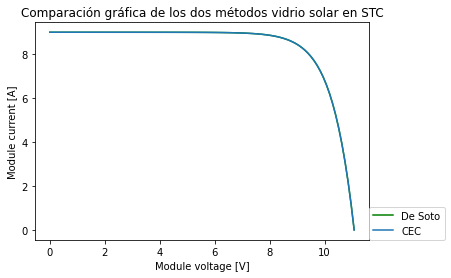

<Figure size 432x288 with 0 Axes>

In [8]:
plt.figure()
i=0

plt.plot(curve_info_d['v'][i], curve_info_d['i'][i], label='De Soto', color='g')    
plt.plot(curve_info_c['v'][i], curve_info_c['i'][i], label='CEC')

plt.legend(loc=(1.0, 0))
plt.xlabel('Module voltage [V]')
plt.ylabel('Module current [A]')
plt.title('Comparación gráfica de los dos métodos vidrio solar en STC')
plt.show()
plt.gcf().set_tight_layout(True)

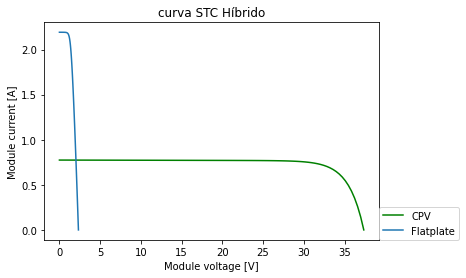

<Figure size 432x288 with 0 Axes>

In [9]:
plt.figure()
i=0

plt.plot(dc_cpv['v'][i], dc_cpv['i'][i], label='CPV', color='g')    
plt.plot(dc_flatplate['v'][i], dc_flatplate['i'][i], label='Flatplate')

plt.legend(loc=(1.0, 0))
plt.xlabel('Module voltage [V]')
plt.ylabel('Module current [A]')
plt.title('curva STC Híbrido')
plt.show()
plt.gcf().set_tight_layout(True)

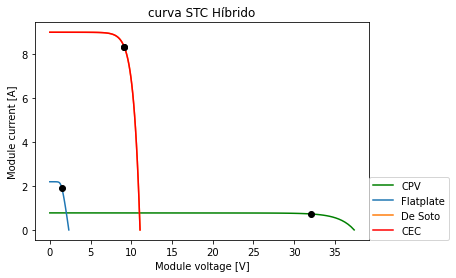

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure()
i=0

plt.plot(dc_cpv['v'][i], dc_cpv['i'][i], label='CPV', color='g')
v_mp = dc_cpv['v_mp'][i]
i_mp = dc_cpv['i_mp'][i]
plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')
    
plt.plot(dc_flatplate['v'][i], dc_flatplate['i'][i], label='Flatplate')
v_mp = dc_flatplate['v_mp'][i]
i_mp = dc_flatplate['i_mp'][i]
plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')

plt.plot(curve_info_d['v'][i], curve_info_d['i'][i], label='De Soto')
v_mp = curve_info_d['v_mp'][i]
i_mp = curve_info_d['i_mp'][i]
plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')
    
plt.plot(curve_info_c['v'][i], curve_info_c['i'][i], label='CEC', color='r')
v_mp = curve_info_c['v_mp'][i]
i_mp = curve_info_c['i_mp'][i]
plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')

plt.legend(loc=(1.0, 0))
plt.xlabel('Module voltage [V]')
plt.ylabel('Module current [A]')
plt.title('curva STC Híbrido')
plt.show()
plt.gcf().set_tight_layout(True)

In [11]:
transparencia=48
dc_vidrio = generacionVidrio(mod_params_vidrio, system, data)*48/transparencia
dc_hibrido = generacionCPV(mod_params_cpv, mod_params_flatplate, system, data)

In [12]:
print(dc_vidrio, "W")
print(dc_hibrido) 

           0
0  42.657563 W
0    23.754442
dtype: float64
